# Transformers: Exercises

Now you have the time to play around with classifiers yourself. We'll use a model for classifying German Party Manifesto contents, and run it on some data on German party manifestos.

The model is `xlm-roberta-large-german-party-cap-v3` by poltextLAB. You should have requested access to it beforehand.

The data we'll be using is coded CAP data on German party manifestos. You can download it from [https://www.comparativeagendas.net/project/germany/datasets](https://www.comparativeagendas.net/project/germany/datasets), but you will also find it in the data folder.

**If you do not have access to the poltextLAB model**, search the [Hugging Face Hub](https://huggingface.co/models) for a model suitable to classify the data. It can be anything - a classifier for sentiment, topics, etc. To start with, I'd suggest that you look for a sentiment classifier. Just make sure it is suitable for German texts! Also be aware that, since we do not have a gold standard for this classifier, you will not be able to systematically evaluate the results.

## Load the Data

You can find the data under `data/manifesto_1949-2013_website-release_2.5_2_3.csv`. Take a look under "Political Parties" at https://www.comparativeagendas.net/project/germany/datasets to learn more about the data set.

*Note*: The data is classified into both CAP major topics and subtopics, but the model only classifies into major topics (max 2 digits).

In [ ]:
import pandas as pd

# ...

### Solution

In [2]:
import pandas as pd

manifesto_de = pd.read_csv('data/manifesto_1949-2013_website-release_2.5_2_3.csv')

manifesto_de.head()

,election_year,party_name,party_id,manifesto_id,sentence_id,cap_topic,cap_subtopic,header,junk,eu_dummy,sentence_text
0,1949,SPD,1,19491,1,99,99,1,0,0,Für ein freies Deutschland
1,1949,SPD,1,19491,2,99,99,0,0,0,Wählerinnen und Wähler!
2,1949,SPD,1,19491,3,99,99,0,0,0,"Am 14. August entscheidet XX darüber, wie ein ..."
3,1949,SPD,1,19491,4,20,2099,0,0,0,Heute ist unser land geteilt.
4,1949,SPD,1,19491,5,20,2099,0,0,0,Swjetrussland hat seine Besatzungszone separiert.


## Load the Model

Load the Model from `poltextlab/xlm-roberta-large-german-party-cap-v3`. 

Check the model page and make sure the CAP code and the model output align. You can chekc the model output labels with the `config.id2label` attribute of your model. You can also use this (and `config.label2id`) to change the labeling.

Build a classifier by using the `pipeline` function. Remember to pass your Hugging Face API token, the tokenizer, and the device if using CUDA

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, pipeline
import os

# ...

### Solution

In [4]:
# device setup

import torch

if torch.cuda.is_available(): # CUDA is the preferred device
    device = 'cuda:0' # note that if you have multiple GPUs, you might want to change this value to not use the first one
    print(f'Cuda Found. Running on {torch.cuda.get_device_name(0)}')
else: 
    if torch.backends.mps.is_available(): # MPS backend for Mac
        device = 'mps'
        print('MPS Found. Running on MPS')
    else: 
        device = 'cpu' # fallback to CPU computing
        print('No GPU Found. Running on CPU')

Cuda Found. Running on NVIDIA GeForce GTX 1060 6GB


In [1]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, pipeline
import os

# load the model
party_model = AutoModelForSequenceClassification.from_pretrained("poltextlab/xlm-roberta-large-german-party-cap-v3")

# check the labels
party_model.config.id2label 

{0: 'Macroeconomics',
 1: 'Civil Rights',
 2: 'Health',
 3: 'Agriculture',
 4: 'Labor',
 5: 'Education',
 6: 'Environment',
 7: 'Energy',
 8: 'Immigration',
 9: 'Transportation',
 10: 'Law and Crime',
 11: 'Social Welfare',
 12: 'Housing',
 13: 'Domestic Commerce',
 14: 'Defense',
 15: 'Technology',
 16: 'Foreign Trade',
 17: 'International Affairs',
 18: 'Government Operations',
 19: 'Public Lands',
 20: 'Culture',
 21: 'No Policy Content'}

In [6]:
# labels are CAP, but not identical to our labeled data. Fix this

CAP_NUM_DICT = {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', # translates Model Output to CAP Major Policy Codes
6: '7', 7: '8', 8: '9', 9: '10', 10: '12', 11: '13', 12: '14', 
13: '15', 14: '16', 15: '17', 16: '18', 17: '19', 18: '20', 19: 
'21', 20: '23', 21: '999'}

party_model.config.id2label = CAP_NUM_DICT # replace the labels with the CAP Major Policy Codes
party_model.config.label2id = {value: key for key, value in CAP_NUM_DICT.items()} # same for the label2id (reversing the dictionary)

party_model.config.id2label # inspect the result

{0: '1',
 1: '2',
 2: '3',
 3: '4',
 4: '5',
 5: '6',
 6: '7',
 7: '8',
 8: '9',
 9: '10',
 10: '12',
 11: '13',
 12: '14',
 13: '15',
 14: '16',
 15: '17',
 16: '18',
 17: '19',
 18: '20',
 19: '21',
 20: '23',
 21: '999'}

In [5]:
# run classifier

# we need to set the tokenizer, in this case the roberta model the classifier is based on
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large") 

classifier = pipeline(task='text-classification', # make classifier pipeline
                      device=device, # this sets the device we prepared earlier
                      model=party_model, 
                      tokenizer = tokenizer, 
                      token=os.environ.get("HF_TOKEN")) 

Device set to use cuda:0


## Run the Model

Classify your data. As this may take a while, it is good practice to first run it on a small sample (e.g. 10 rows of your data) to make sure it works, and save the output after you ran your whole dataset.

If you do not want to wait for the whole data to be processed by the model, you can also just run it on a subset. In this case, you can set a seed and use `sample()` to draw a random sample.

In [ ]:
# ...

### Solution

In [30]:
# take a random sample of 500 sentences to speed up the process

seed = 20250227 # set a random seed before sampling to reproduce the results

classification_data = manifesto_de.sample(n=500, random_state=seed) # sample 500 sentences

classifications = classifier(list(classification_data["sentence_text"])) # we only classify 500 sentences here

## Evaluation

**If not using the poltextLAB model, systematic evaluation will not be possible.** In this case, I suggest you look at a number of results to get a feeling for how well your model did. If you wanted to do a proper evaluation, you would need to manually code a percentage of your data and compare it to your model output.



### Model and Data compability

Check if your data and model have the same coded CAP categories. If the data has categories not available to the model, you might want to make a new dataset that drops these before calulating the evaluation metrics. If this is the case, take a closer look at the categories also: Which categories did the model predict for the categories it did not know?

In [ ]:
# ...

#### Solution

In [32]:
# merge data

classification_data.reset_index(drop=True, inplace=True) # reset the index to merge the data

classification_results = pd.concat([classification_data, pd.DataFrame(classifications)], axis=1) # turn classificaion into DF and merge

classification_results


,election_year,party_name,party_id,manifesto_id,sentence_id,cap_topic,cap_subtopic,header,junk,eu_dummy,sentence_text,label,score
0,2009,SPD,1,20091,1646,14,1405,0,0,0,La?ndliche Ra?ume machen la?ngst einen Transfo...,14,0.962429
1,1998,Grünen,4,19984,958,15,1500,0,0,0,Eine wesentliche Reformoption muss die Sicheru...,15,0.654613
2,2013,CDU,2,20132,601,1,107,0,0,0,Starke Schultern mu?ssen mehr tragen als schwa...,1,0.822742
3,2005,SPD,1,20051,260,20,2012,1,0,0,Lebendige Demokratie und offene Gesellschaft.,20,0.861395
4,1998,Grünen,4,19984,65,99,99,0,0,0,Die Kohl-Regierung vermittelt den Menschen das...,1,0.608777
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2013,FDP,3,20133,1424,2,208,0,0,0,Im Mittelpunkt unseres Denkens und Handelns st...,2,0.931274
496,1990,FDP,3,19903,659,5,500,0,0,0,Die von der Bundesanstalt für Arbeit gefördert...,5,0.923981
497,1998,PDS,5,19985,290,7,700,0,0,0,Die Bewahrung und Wiederherstellung der natürl...,7,0.960360
498,1998,Grünen,4,19984,2236,16,1608,0,0,0,Die Abschaffung staatlicher Zwangsdienste soll...,16,0.953376


In [33]:
sorted([int(value) for value in manifesto_de['cap_topic'].unique()]) # categories 25 and 61 are not in the model

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 23,
 25,
 61,
 99]

In [34]:
# check what the model predicted for unkown categories

print(classification_results[classification_results['cap_topic'] == 25])

print(classification_results[classification_results['cap_topic'] == 61])

Empty DataFrame
Columns: [election_year, party_name, party_id, manifesto_id, sentence_id, cap_topic, cap_subtopic, header, junk, eu_dummy, sentence_text, label, score]
Index: []
Empty DataFrame
Columns: [election_year, party_name, party_id, manifesto_id, sentence_id, cap_topic, cap_subtopic, header, junk, eu_dummy, sentence_text, label, score]
Index: []


In [35]:
# drop unkown categories

classification_results = classification_results[classification_results['cap_topic'] != 25]
classification_results = classification_results[classification_results['cap_topic'] != 61]

### Evaluation Metrics

Calculate the Accuracy, Precision, Recall and F1 Score both across all categories and for each category individually. Are there any categories that fare better or worse than the rest? Why could that be?

Also take a closer look at the additional variables in our data. Are the evaluation metrics dependant on the year or the party? Maybe the model struggles for certain periods or parties? Visualize this with plots.

Hint: You might need to turn the CAP-labelling into string with `astype(str)` to calculate metrics.

Note: If you pulled a random sample with `sample()`, you'll want to sort your data by year with `sort_values()` before plotting over time.

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

classification_results["cap_topic"] = classification_results["cap_topic"].astype(str) # convert to str for metrics

accuracy = accuracy_score(classification_results["cap_topic"], classification_results["label"])
precision = precision_score(classification_results["cap_topic"], classification_results["label"], average="weighted")
recall = recall_score(classification_results["cap_topic"], classification_results["label"], average="weighted")
f1 = f1_score(classification_results["cap_topic"], classification_results["label"], average="weighted")

print(
    f'Accuracy: {accuracy}\n'
    f'Precision: {precision}\n'
    f'Recall: {recall}\n'
    f'F1: {f1}'
)

Accuracy: 0.708
Precision: 0.6587963079632256
Recall: 0.708
F1: 0.6757281278303078


c:\ProgramData\miniconda3\envs\nlp_workshop\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
from sklearn.metrics import classification_report

print(classification_report(classification_results["cap_topic"], classification_results["label"]))

              precision    recall  f1-score   support

           1       0.46      0.80      0.59        41
          10       0.85      0.89      0.87        19
          12       0.62      0.76      0.68        21
          13       0.63      0.82      0.71        33
          14       0.89      0.80      0.84        20
          15       0.75      0.65      0.70        23
          16       0.70      0.74      0.72        19
          17       0.78      0.93      0.85        15
          18       0.25      0.67      0.36         3
          19       0.69      0.63      0.66        49
           2       0.74      0.76      0.75        38
          20       0.57      0.73      0.64        22
          21       0.00      0.00      0.00         2
          23       0.50      0.40      0.44         5
           3       0.94      0.94      0.94        16
           4       0.89      0.80      0.84        10
           5       0.78      0.91      0.84        32
           6       0.92    

c:\ProgramData\miniconda3\envs\nlp_workshop\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\nlp_workshop\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\nlp_workshop\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

<BarContainer object of 6 artists>

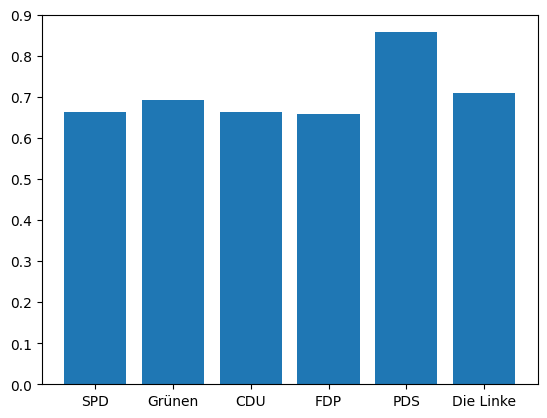

In [40]:
# Visualize for parties

import matplotlib.pyplot as plt

f1_scores = []

for party in classification_results['party_name'].unique():
    party_data = classification_results[classification_results['party_name'] == party]
    f1 = f1_score(party_data["cap_topic"], party_data["label"], average="weighted")
    f1_scores.append(f1)

plt.bar(classification_results['party_name'].unique(), f1_scores)


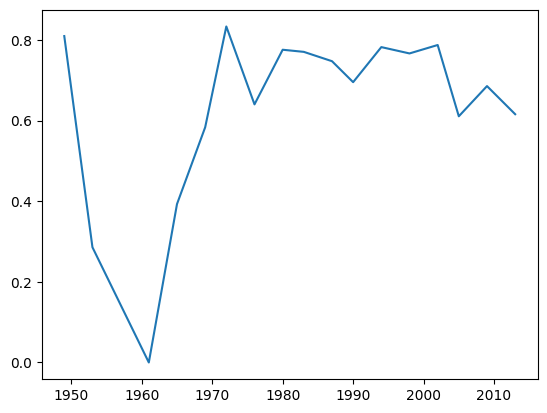

In [41]:
# Visualize for years (this will not work for the 100 sentence subsample, as we have only 1 year there)

import matplotlib.pyplot as plt

# sort data by year (ascending)
classification_results = classification_results.sort_values(by='election_year')

f1_scores = []

for year in classification_results['election_year'].unique():
    year_data = classification_results[classification_results['election_year'] == year]
    f1 = f1_score(year_data["cap_topic"], year_data["label"], average="weighted")
    f1_scores.append(f1)

plt.plot(classification_results['election_year'].unique(), f1_scores)

## Bonus: New Data

As mentioned before, it is likely that this specific data set has been used for training the model. Can you find some other data to run the model on? Maybe from your own research, or a paper that has made its data available?

If you do not wish to work with German-language data, you might need to use another model, such as the English media model used in the previous notebook.

Note that you will likely not have a gold standard for this data that you can directly evaluate the model output with (unless, of course, you have some CAP-coded data). In this case, you can still inspect the results to get a feeling how well the model did. A proper evaluation would require you to CAP-code the data, though!